In [1]:
import torch
import torch.nn as nn
from torchvision.models.video import r3d_18
import nibabel as nib
import numpy as np
from lime import lime_image
from skimage.color import gray2rgb
import pandas as pd
import random

In [2]:
class SEBlock(nn.Module):
    def __init__(self, input_dim, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, input_dim // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(input_dim // reduction, input_dim, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        self.saved_attention = y
        return x * y.expand_as(x)

class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.se_block = SEBlock(planes * self.expansion)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Apply SE block
        out = self.se_block(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

    def get_attention_weight(self):
        return self.se_block.saved_attention

# Load the pre-built 3D ResNet model
model = r3d_18(pretrained=True, progress=True)

# Replace the first convolution layer for single-channel input
model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)

# Replace existing blocks with SEBasicBlock
def make_layer(block, inplanes, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or inplanes != planes * block.expansion:
        downsample = nn.Sequential(
            nn.Conv3d(inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm3d(planes * block.expansion),
        )

    layers = []
    layers.append(block(inplanes, planes, stride, downsample))
    inplanes = planes * block.expansion
    for _ in range(1, blocks):
        layers.append(block(inplanes, planes))

    return nn.Sequential(*layers)

# if you want 18 layers, use the following
model.layer1 = make_layer(SEBasicBlock, 64, 64, 2)
model.layer2 = make_layer(SEBasicBlock, 64, 128, 2, stride=2)
model.layer3 = make_layer(SEBasicBlock, 128, 256, 2, stride=2)
model.layer4 = make_layer(SEBasicBlock, 256, 512, 2, stride=2)

# if you want 9 layers, use the following
# model.layer1 = make_layer(SEBasicBlock, 64, 64, 1) 
# model.layer2 = make_layer(SEBasicBlock, 64, 128, 1, stride=2)  
# model.layer3 = make_layer(SEBasicBlock, 128, 256, 1, stride=2) 
# model.layer4 = make_layer(SEBasicBlock, 256, 512, 1, stride=2)  

# Replace the fully connected layer for specific output size
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=3)

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Using device:", device)


Using device: cuda


In [3]:
weights_path = r'D:\Work\Python_code\Medical_image\1126\model_weights_epoch_30.pth'
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [4]:
file_path = r'D:\Work\Medical image\2023\auto_noCCseg\041_S_6226.nii'  # Please replace with your file path
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()
image_data_torch=torch.tensor(image_data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)
output = model(image_data_torch)
print(output)

tensor([[ 0.8887, -0.3520, -2.1186]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [5]:
import numpy as np
import torch
from sklearn.linear_model import LinearRegression

def predict(model, data):
    """
    使用模型进行预测的函数。
    """
    data_torch=torch.tensor(data[np.newaxis,np.newaxis, ...], dtype=torch.float32).to(device)
    with torch.no_grad():
        return model(data_torch).detach().to('cpu').numpy()

def generate_perturbations(data, mask,model,num_samples=50,method='shaded'):
    """
    生成扰动样本。
    """
    num_regions = int(np.max(mask))  # 假设区域编号从1到最大值
    Y = []
    X = []

    for _ in range(num_samples):
        # 随机选择一半区域进行扰动
        region_to_perturb = random.sample(range(1, num_regions), int(num_regions/2))
        result_array = np.ones(num_regions, dtype=int)
        for index in region_to_perturb:
            if 0 <= index < len(result_array):
                result_array[index] = 0
        X.append(result_array)

        # 生成扰动
        perturbed_sample = np.copy(data)
        if method=='noise':
            perturbation = np.random.normal(0, 0.1, data.shape)
            for region in region_to_perturb:
                perturbed_sample[mask == region] += np.random.normal(0,0.1,perturbed_sample[mask == region].shape)
        elif method=='shaded':
            for region in region_to_perturb:
                perturbed_sample[mask == region] =0
                
        Y.append(predict(model,perturbed_sample)[0])
    
    return X, Y

In [6]:
input_data = image_data
X, Y = generate_perturbations(input_data,input_data,model, 50,'shaded')
Y=np.array(Y)


regressor0 = LinearRegression()
regressor1 = LinearRegression()
regressor2 = LinearRegression()
regressor0.fit(X, Y[:,0])
regressor1.fit(X, Y[:,1])
regressor2.fit(X, Y[:,2])

print(regressor0.coef_)
print(regressor1.coef_)
print(regressor2.coef_)

[-0.0001531   0.0090309   0.00417644  0.01196736 -0.00044701  0.00705852
 -0.00086322  0.00482881 -0.00756557  0.00148679 -0.00603336  0.00369687
  0.00998938  0.01465857 -0.00335784 -0.00863095 -0.00314325  0.00759892
  0.00325103 -0.00922765 -0.00943512  0.00054791  0.01129126 -0.00980141
 -0.01070589 -0.02592804 -0.0073164   0.00171692  0.00654171 -0.01471432
  0.00412181  0.00029425 -0.00222767  0.00118759  0.01215017  0.01109202
 -0.00140846  0.01041882  0.00893383 -0.00929048 -0.02059968  0.02930951
 -0.00238649 -0.00950833 -0.00142102  0.02987966 -0.00412303  0.00047301
 -0.00029684  0.0007025   0.00093226  0.00122392 -0.0161534   0.0079293
 -0.00412292 -0.00416289  0.01036242  0.0068552  -0.00835309 -0.0018055
  0.01066877 -0.01977952  0.00238866  0.00525069 -0.01127179 -0.01262105
  0.01148671  0.00666766  0.01066496  0.00127394 -0.00813597  0.00449702
 -0.01090259 -0.01719446 -0.01867691  0.01004231  0.00449214]
[ 0.00022556 -0.00611749 -0.00278349 -0.00822475  0.00101083 -0.

In [7]:
pd.DataFrame([regressor0.coef_,regressor1.coef_,regressor2.coef_],columns=range(1,78)).to_csv(r'D:\Work\Medical image\2023\Lime_result\041_S_6226_shaded.csv')

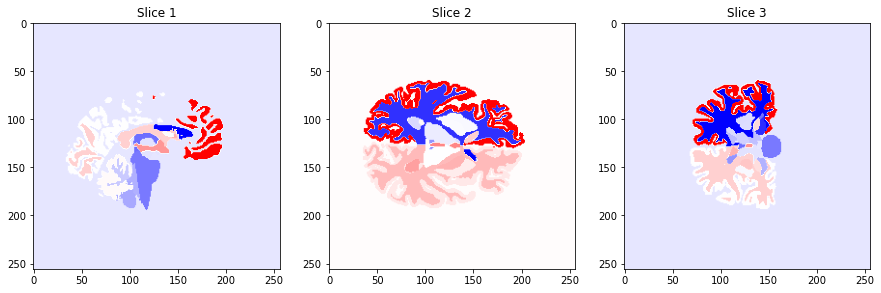

In [27]:
import matplotlib.pyplot as plt

def normalize_11(array):
    return 2 * (array - array.min()) / (array.max() - array.min()) - 1

def get_interpretation(mri_image,array):
    normalized_array = normalize_11(array)
    for i in range(len(normalized_array)):
        mri_image[mri_image == i+1] = normalized_array[i]
    
    return mri_image

mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()
mri_image=get_interpretation(image_data,regressor0.coef_)

slice1 = mri_image[mri_image.shape[0] // 2, :, :]
slice2 = mri_image[:, mri_image.shape[1] // 2, :]
slice3 = mri_image[:, :, mri_image.shape[2] // 2]

cmap = plt.cm.bwr

# Plot the slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(slice1, cmap=cmap)
axes[0].set_title('Slice 1')
axes[1].imshow(slice2, cmap=cmap)
axes[1].set_title('Slice 2')
axes[2].imshow(slice3, cmap=cmap)
axes[2].set_title('Slice 3')
plt.show()

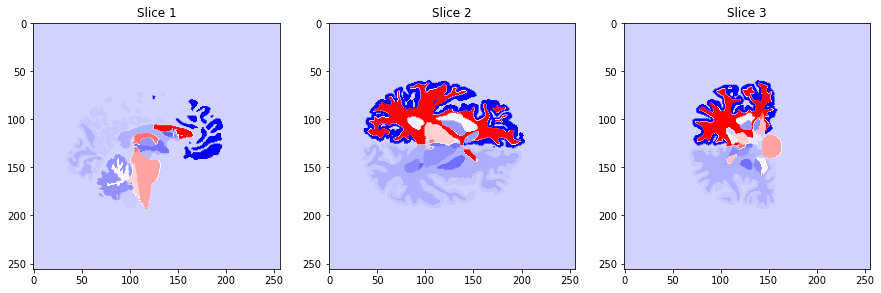

In [28]:
import matplotlib.pyplot as plt

def normalize_11(array):
    return 2 * (array - array.min()) / (array.max() - array.min()) - 1

def get_interpretation(mri_image,array):
    normalized_array = normalize_11(array)
    for i in range(len(normalized_array)):
        mri_image[mri_image == i+1] = normalized_array[i]
    
    return mri_image

mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()
mri_image=get_interpretation(image_data,regressor2.coef_)

slice1 = mri_image[mri_image.shape[0] // 2, :, :]
slice2 = mri_image[:, mri_image.shape[1] // 2, :]
slice3 = mri_image[:, :, mri_image.shape[2] // 2]

cmap = plt.cm.bwr

# Plot the slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(slice1, cmap=cmap)
axes[0].set_title('Slice 1')
axes[1].imshow(slice2, cmap=cmap)
axes[1].set_title('Slice 2')
axes[2].imshow(slice3, cmap=cmap)
axes[2].set_title('Slice 3')
plt.show()

In [20]:
normalize_11(regressor0.coef_)

array([-0.0762944 ,  0.25283576,  0.07886457,  0.35807055, -0.0868274 ,
        0.18215082, -0.1017433 ,  0.10224401, -0.34193756, -0.01752511,
       -0.28702737,  0.06167826,  0.28718496,  0.45451632, -0.19114401,
       -0.38011822, -0.18345368,  0.20151748,  0.04570057, -0.40150208,
       -0.40893739, -0.05117201,  0.33384084, -0.42206425, -0.45447841,
       -1.        , -0.33300797, -0.00927796,  0.16362964, -0.59813007,
        0.07690692, -0.0602627 , -0.15064162, -0.02824758,  0.36462199,
        0.32670068, -0.12128327,  0.30257516,  0.24935679, -0.40375384,
       -0.80904555,  0.97956736, -0.15633338, -0.41156099, -0.12173325,
        1.        , -0.21856621, -0.05385652, -0.08144591, -0.04563207,
       -0.03739814, -0.02694582, -0.64970284,  0.21335738, -0.21856224,
       -0.21999471,  0.30055391,  0.17486421, -0.37016017, -0.13551216,
        0.31153264, -0.7796531 ,  0.01479561,  0.11736296, -0.47475884,
       -0.52311251,  0.34084554,  0.16814337,  0.31139605, -0.02

In [21]:
normalize_11(regressor2.coef_)

array([ 0.0501408 , -0.11263562, -0.03316076, -0.23565521, -0.24432075,
       -0.11551313,  0.18094616, -0.21184217,  0.23284666, -0.19443398,
        0.34892965, -0.10724809, -0.32467041, -0.30493031,  0.28518372,
        0.44238054,  0.18484627, -0.23496527, -0.10053566,  0.22138728,
        0.30093948,  0.0265521 , -0.47716676,  0.61672169,  0.70543755,
        1.        ,  0.35414463, -0.08570028, -0.15567838,  0.64205052,
       -0.35583439,  0.16165324,  0.10410021,  0.43316408, -0.26967164,
       -0.19022307,  0.01825157, -0.23435744, -0.32989143,  0.44933304,
        0.98304998, -0.68861906,  0.10161763,  0.5782797 ,  0.07192614,
       -1.        , -0.02624203,  0.14406069,  0.31027897, -0.00260007,
        0.12296379, -0.18278657,  0.36671249, -0.22081127,  0.27275682,
        0.07019183, -0.11543211, -0.16612108,  0.50167841,  0.06563526,
       -0.37185285,  0.49474733,  0.17264157, -0.18047454,  0.43673554,
        0.41050268, -0.18791167, -0.14981003, -0.11183218, -0.13

In [26]:
mri_image = nib.load(file_path)
image_data = mri_image.get_fdata()
image_data[image_data==2]

array([2., 2., 2., ..., 2., 2., 2.])

## Visualize the model

In [ ]:
from torchsummary import summary

summary(model,(1,256,256,256),device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1    [-1, 64, 256, 128, 128]           9,408
       BatchNorm3d-2    [-1, 64, 256, 128, 128]             128
              ReLU-3    [-1, 64, 256, 128, 128]               0
            Conv3d-4    [-1, 64, 256, 128, 128]         110,592
       BatchNorm3d-5    [-1, 64, 256, 128, 128]             128
              ReLU-6    [-1, 64, 256, 128, 128]               0
            Conv3d-7    [-1, 64, 256, 128, 128]         110,592
       BatchNorm3d-8    [-1, 64, 256, 128, 128]             128
 AdaptiveAvgPool3d-9          [-1, 64, 1, 1, 1]               0
           Linear-10                    [-1, 4]             256
             ReLU-11                    [-1, 4]               0
           Linear-12                   [-1, 64]             256
          Sigmoid-13                   [-1, 64]               0
          SEBlock-14    [-1, 64, 256, 1

D:\Software\Anaconda3\envs\pytorch\lib\site-packages\torchsummary\torchsummary.py:93: RuntimeWarning: overflow encountered in long_scalars
  total_output += np.prod(summary[layer]["output_shape"])
